# Deep Learning for Zero-shot Classification


## Table of Contents




<!-- MarkdownTOC autolink="true" autoanchor="true" bracket="round" -->
- [Overview](#overview)
- [Part 1 - What is Zero-shot Learning?](#whatiszsl)
  - [Regression for Zero-shot Learning](#regression_for_zsl)
  - [Experimental Setting](#experimental_setting)
- [Part 2 - Transfer Learning for Zero-shot Learning by Inception(v3/v5) and VGG16](#part1_vgg_inception_zsl)
- [Part 3 - Convolutional Autoencoder for Zero-shot Learning](#ae_for_zsl)
- [Part 4 - Deep Regression for Zero-shot Learning](#dr_zsl)
- [Part 5 - Extra](#fea_ext)
<a name="overview"></a>
# Overview

In this project, we attempt to solve zero-shot learning problem by deep learning techniques. Part 1 shows what zero-shot learning problem is, and simple regression method for zero-shot classification. Also, it introduces the dataset we are going to use throught this project. Part 2 presents transfer learning for zero-shot learning by well-known deep artitechtures, namely Inception and VGG. Part 3 shows how autoencoders can be used for zero-shot learning problem. In Part 4, we build a deep regression model for zero-shot learning. Finally, I show how to extract features and do fine-tuning.

In [18]:
# First check the Python version
# print(tf.__version__)
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from numpy.linalg import inv
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, nb_utils
    
except ImportError as e:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.")
    print(e)

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="whatiszsl"></a>
# Part 1 - What is Zero-shot Learning?

Zero-shot learning problem is a classification problem. To understand clearly, first let's recall conventional classificaiton problem, in which we split dataset into test and training set. The test set and training set have a <strong>joint</strong> label space. For example, say we want a cat classifation model from the image. Assume that we have a dataset of cat images. Conventinally, what we do is we split the dataset into train and test set. We train the model with train set and test the model with the test set. Clearly, both sets contain cat images thus the labels space are the same. 

The label space are <strong>DISJOINT</strong> in zero-shot classification. That is, we train a model with cat. But, we apply it to the dog classification. How is it possible?! 

Well, there is no free lunch. The trick is that zero-shot learning relies on some extra side-information in addition to the labels. The side information is usually semantic information which could be attributes. An assumption is that both the train and the test set share semantic information (again attributes, for example panda and zebra have 'white and black' attribute). Therefore, most current zero-shot learning methods try to embed the both sets into the shared space (in this case attribute space). That is, they try to learn some function that can project the training set and the test set samples into the shared space. This space is also called semantic space (or embedding space), since attributes are in fact semantically meaningful, e.g. has "nose", "bald", "curly". The procedure is also called "embedding". 

With the embedding function, a given new sample can be embedded into into semantic space, and zero-shot classification can be done by simply nearest neighbour classification. 

In zero-shot learning, the training set classes is called 'seen' classes, while the testing set classes is called 'unseen' classes. 
To sum up, zero-shot classifaction has mainly two steps:
1. Learning embedding function from the seen classes and the semantic information
2. Apply the embedding function to samples from the unseen class, and do nearest neighbour classification in the semantic space

Formally, lets denote the data features from seen classes is $X_{seen}$, and that of unseen classes is $X_{unseen}$. Similarly, corresponding semantic information is $S_{seen}$ and $S_{unseen}$, respectively. (1) Using $X_{seen}$ and $S_{train}$ we learn an embedding function $W$ using some method (will be shown later). Note that $W$ makes a connection between the data features and the semantic information. Also, note that $S$ is not label rather it is attribute matrix. (2) After learning the embedding function, we project the given sample from unseen class using $W$ to the semantic space. And then, we do simply nearest neighbour classification.   

The figure below illustrates a big picture of zero-shot classification:

<img src = "images_project/concept_zsl.jpg" height="600" width="450"></img>


<a name="regression_for_zsl"></a>
## Regression for Zero-shot Learning
In the previous section, we mentioned the learning of the embedding function. Now we see the simplest method to learn such kind of function using regression. More specifically, we make a connection between features of the data from seen classes and their corresponding semantic information.

We can formulate the regression for zero-shot learning as follows:

\begin{align}
\Large{\min_{W} \|X_{seen}W - S_{seen}\|_F^2 + \lambda \|W\|_F^2}
\end{align}

$X_{seen} \in R^{N \times k}$ is $N$ number of samples with k-dimensional feature vector, $S_{seen} \in R^{N \times d}$ is $N$ number of samples with $d$-dimensional attribute vector, $W \in R^{k \times d}$ is the embedding function, and $\lambda$ is a regularisation parameter (note that in this work we do not tune this parameter carefully i.e. cross-validation).

This formulation has a closed-form solution:

\begin{align}
\Large{W} = (X^TX + \lambda I)^{-1}X^TS
\end{align}

Ok, now let's look at how we apply $W$ to the unseen classes. Let's say we have a sample from unseen classes, $x_{unseen}$. We just simply do matrix multiplication -- projection. 

\begin{align}
\Large{S_{unseen}^{est} = W^TX_{unseen}}
\end{align}

After that, we do the nearest neighbour classification in the semantic (embedding) space.
\begin{align}
\Large{{\hat{z}} = \arg \min_{z} \|S_{unseen}^{est} - S_z^{prototype}\|_2^2)}
\end{align}

$\hat{z}$ is the predicted label.




## Helper Functions

There are a few helper functions which are helpful to do zero-shot classification.

In [19]:
import sklearn.metrics.pairwise
import scipy.spatial.distance
from scipy.misc import imrotate


def NormaliseRows(S_te_pro):
    ''' This function normalises the input matrix.
    S_te_pro: input matrix
    
    '''
    
    S_te_pro_T = np.transpose(S_te_pro)
    normF      = np.sqrt(np.sum(np.multiply(S_te_pro_T,S_te_pro_T), axis = 1))
    normFUsed  = normF
    normFUsed[normFUsed == 0] = 1
    
    for i in range(normFUsed.shape[0]):
        S_te_pro_T[i,:] = S_te_pro_T[i,:]/normFUsed[i]
    
    return np.transpose(S_te_pro_T)


def knn_zsl_el(a_est_g, S_te_pro, X_te_Y, te_cl_id):
    ''' a_est_g   : [k, N] estimated semantic attribute matrix
        S_te_pro  : [c, k] prototype
        X_te_Y    : [N, 1] ground truth labels
        te_cl_id  : [c,1]  label id
        N         : the number of samples
        k         : attribute dimension size
        c         : the number of classes
        
        Return:
        Acc       : Accuracy
        Y_est     : Estimated labels
    '''
    
    dist1 = 1 - sklearn.metrics.pairwise.pairwise_distances(np.transpose(a_est_g), NormaliseRows(S_te_pro),'cosine')
    Z_est = [];
    for i in range(len(dist1)):
        I = sorted(range(len(dist1[i,:])), key=lambda k: dist1[i,:][k])
        Z_est.append(te_cl_id[I[-1]])
        
    X_te_Y =X_te_Y[:]
    X_te_Y = np.array(X_te_Y[:])
    Z_est  = np.array(Z_est)

    n=0;
    for i  in range(len(dist1)):
        if (X_te_Y[i] == Z_est[i]):
            n = n + 1;
    
    Acc = n/len(dist1)
    
    #print('{:0.3f}'.format (Acc))
    return Acc, Z_est


def data_augment(im, net):
    n        = 1
    shift    = 15
    img_rot  = imrotate(im, 180)

    d= {}
    d[0]    = net['preprocess'](im, crop = False)  
#     n = n + 1
#     d[1]    = net['preprocess'](im[0:img.shape[0] - shift, 0:img.shape[1] - shift], crop=False)  
#     n = n + 1
#     d[2]    = net['preprocess'](im[shift:img.shape[0],     0:img.shape[1] - shift], crop=False)   
#     n = n + 1
#     d[3]    = net['preprocess'](im[0:img.shape[0] - shift, shift:img.shape[1]], crop=False)      
#     n = n + 1
#     d[4]    = net['preprocess'](im[shift:img.shape[0],     shift:img.shape[1]], crop=False)       
#     n = n + 1
#     d[5]    = net['preprocess'](im[shift:img.shape[0]-shift,  shift:img.shape[1]-shift], crop=False)    
#     n = n + 1
#     d[6]    = net['preprocess'](img_rot, crop = False)  
#     n = n + 1
#     d[7]    = net['preprocess'](img_rot[0:img.shape[0] - shift, 0:img.shape[1] - shift], crop=False)   
#     n = n + 1
#     d[8]    = net['preprocess'](img_rot[shift:img.shape[0],     0:img.shape[1] - shift], crop=False)   
#     n = n + 1
#     d[9]    = net['preprocess'](img_rot[0:img.shape[0] - shift, shift:img.shape[1]], crop=False)       
#     n = n + 1
#     d[10]    = net['preprocess'](img_rot[shift:img.shape[0],     shift:img.shape[1]], crop=False)           
#     n = n + 1
#     d[11]    = net['preprocess'](img_rot[shift:img.shape[0]-shift,  shift:img.shape[1]-shift], crop=False)     

#     fig, axs = plt.subplots(2, 6, figsize = (10,15))
#     t = 0
#     for i in range(2):
#         for j in range(6):
#             axs[i][j].imshow(d[t] / 255.0)
#             t += 1 

    fea = np.zeros((n, 1024))
    for i in range(n):
        with tf.Session(graph=g) as sess, g.device('/cpu:0'):
            fea[i, :] = avg_pool.eval(feed_dict={x: d[i][np.newaxis]})[0]

    return np.mean(fea, axis=0)


<a name="experimental_setting"></a>
## Experimental Setting
We use benchmark CUB dataset for the experiments: The number of classes is 200 bird classess, and the number of images is 11,178, and each class has 312 dimensional attribute vector. Some examples are given below. 150 classes are chosen as seen classes, while the remaining ones are unseen classes.  
<img src = "images_project/cub.jpg" height="900" width="650"></img>




<a name="part1_vgg_inception_zsl"></a>
# Part 2 - Transfer Learning for Zero-shot Learning by Inception(v3/v5) and VGG16

In this section, we extract features from CUB dataset images by Inception and VGG to perform zero-shot classification.

## Preparing the dataset
Following code does following things: reading images and attribute vectors, and storing them to matrix (matrix) so that we can use them in later sections. 

In [20]:
import csv
from scipy.misc import imresize

# Path to the image files
PATH        = 'CUB/CUB_200_2011_box/images'
files   = [os.path.join(PATH, file_i) for file_i in os.listdir(PATH)]

images = []
with open('CUB/CUB_200_2011_box/images.txt', newline='') as inputfile:
    for row in csv.reader(inputfile):
        images.append(row[0].split(' ')[1])
        
images = np.array(images)

ATTRIBUTES_temp = []
with open('CUB/CUB_200_2011_box/attributes/class_attribute_labels_continuous.txt', newline='') as inputfile:
    for row in csv.reader(inputfile):
        ATTRIBUTES_temp.append(row[0])
ATTRIBUTES_temp = np.array(ATTRIBUTES_temp)

ATTRIBUTES = np.zeros((200, 312))
for i in range(200):
    str1 = ATTRIBUTES_temp[i].split(' ')
    for j, content in enumerate(str1):
        ATTRIBUTES[i,j] = content

### Seen (Train) classes
train_classes = []
with open('CUB/CUB_200_2011_box/trainclasses_akata.txt', newline='') as inputfile:
    for row in csv.reader(inputfile):
        train_classes.append(row)
train_classes = np.array(train_classes)
        
### Unseen (Test) classes
test_classes = []
with open('CUB/CUB_200_2011_box/testclasses_akata.txt', newline='') as inputfile:
    for row in csv.reader(inputfile):
        test_classes.append(row)
test_classes = np.array(test_classes)



## Seen classes
N = 8855 # the number of images for seen classes
k = 4096 # feature dimension
d = 312  # attribute dimension
c = 150   # the number of unseen classes

S_train             = np.zeros((N, d)) # Attribute
files_train         = []
index_counter_train = 0                # Counter

for i in range(c): #150
    print(index_counter_train)
    for j in range(images.shape[0]):
        if (images[j].split('/')[0] == train_classes[i][0].split(' ')[1]):                  
            files_train.append(os.path.join('CUB/CUB_200_2011_box/images/', images[j]))
            S_train[index_counter_train, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
            index_counter_train += 1
            
# Unseen classes
N = 2933 # the number of images for seen classes
k = 4096 # feature dimension
d = 312  # attribute dimension
c = 50   # the number of unseen classes

S_test             = np.zeros((N, d)) # Attribute
files_test         = []
Y_test             = []
index_counter_test = 0                # Counter

for i in range(c):
    print(index_counter_test)
    for j in range(images.shape[0]):
        if (images[j].split('/')[0] == test_classes[i]):        
            files_test.append(os.path.join('CUB/CUB_200_2011_box/images/', images[j]))
            Y_test.append(int(images[j][0:3])-1)
            S_test[index_counter_test, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
            index_counter_test += 1
        

0
60
118
162
215
275
335
391
451
509
567
624
669
728
787
847
903
955
1015
1075
1135
1194
1254
1307
1366
1426
1486
1546
1606
1666
1726
1786
1846
1906
1966
2026
2086
2146
2206
2264
2324
2383
2443
2503
2563
2623
2673
2733
2793
2853
2913
2973
3033
3093
3150
3210
3270
3329
3389
3449
3509
3569
3629
3689
3749
3809
3869
3929
3989
4048
4108
4168
4228
4277
4337
4396
4456
4516
4576
4636
4686
4745
4805
4864
4924
4984
5044
5104
5163
5222
5281
5341
5401
5461
5521
5581
5641
5701
5761
5821
5881
5941
5999
6059
6119
6179
6239
6299
6359
6418
6478
6529
6589
6648
6708
6768
6827
6887
6947
7006
7066
7126
7186
7246
7305
7364
7424
7484
7544
7604
7664
7724
7784
7844
7900
7959
8018
8078
8138
8198
8258
8316
8376
8436
8496
8556
8616
8675
8735
8795
0
60
120
161
209
268
328
387
447
507
566
625
685
745
804
864
923
983
1043
1103
1163
1223
1283
1343
1396
1456
1516
1576
1636
1696
1746
1806
1866
1926
1986
2045
2105
2165
2224
2284
2344
2404
2464
2524
2583
2643
2703
2763
2823
2873


## Preparing the Inception
We get an inception model using the course lib.

In [14]:
# Get the model
tf.reset_default_graph()
from libs import inception
net = inception.get_inception_model()
g = tf.Graph()

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tf.import_graph_def(net['graph_def'], name='inception') 
    names = [op.name for op in g.get_operations()]

for f in names:
    print(f)


inception/input
inception/conv2d0_w
inception/conv2d0_b
inception/conv2d1_w
inception/conv2d1_b
inception/conv2d2_w
inception/conv2d2_b
inception/mixed3a_1x1_w
inception/mixed3a_1x1_b
inception/mixed3a_3x3_bottleneck_w
inception/mixed3a_3x3_bottleneck_b
inception/mixed3a_3x3_w
inception/mixed3a_3x3_b
inception/mixed3a_5x5_bottleneck_w
inception/mixed3a_5x5_bottleneck_b
inception/mixed3a_5x5_w
inception/mixed3a_5x5_b
inception/mixed3a_pool_reduce_w
inception/mixed3a_pool_reduce_b
inception/mixed3b_1x1_w
inception/mixed3b_1x1_b
inception/mixed3b_3x3_bottleneck_w
inception/mixed3b_3x3_bottleneck_b
inception/mixed3b_3x3_w
inception/mixed3b_3x3_b
inception/mixed3b_5x5_bottleneck_w
inception/mixed3b_5x5_bottleneck_b
inception/mixed3b_5x5_w
inception/mixed3b_5x5_b
inception/mixed3b_pool_reduce_w
inception/mixed3b_pool_reduce_b
inception/mixed4a_1x1_w
inception/mixed4a_1x1_b
inception/mixed4a_3x3_bottleneck_w
inception/mixed4a_3x3_bottleneck_b
inception/mixed4a_3x3_w
inception/mixed4a_3x3_b
in

Let's look at how to extract features for an example image of coffee. We can use 'inception/avgpool0/reshape' layer to extract features which gives 1024-dimensional feature vector.

(1024,)


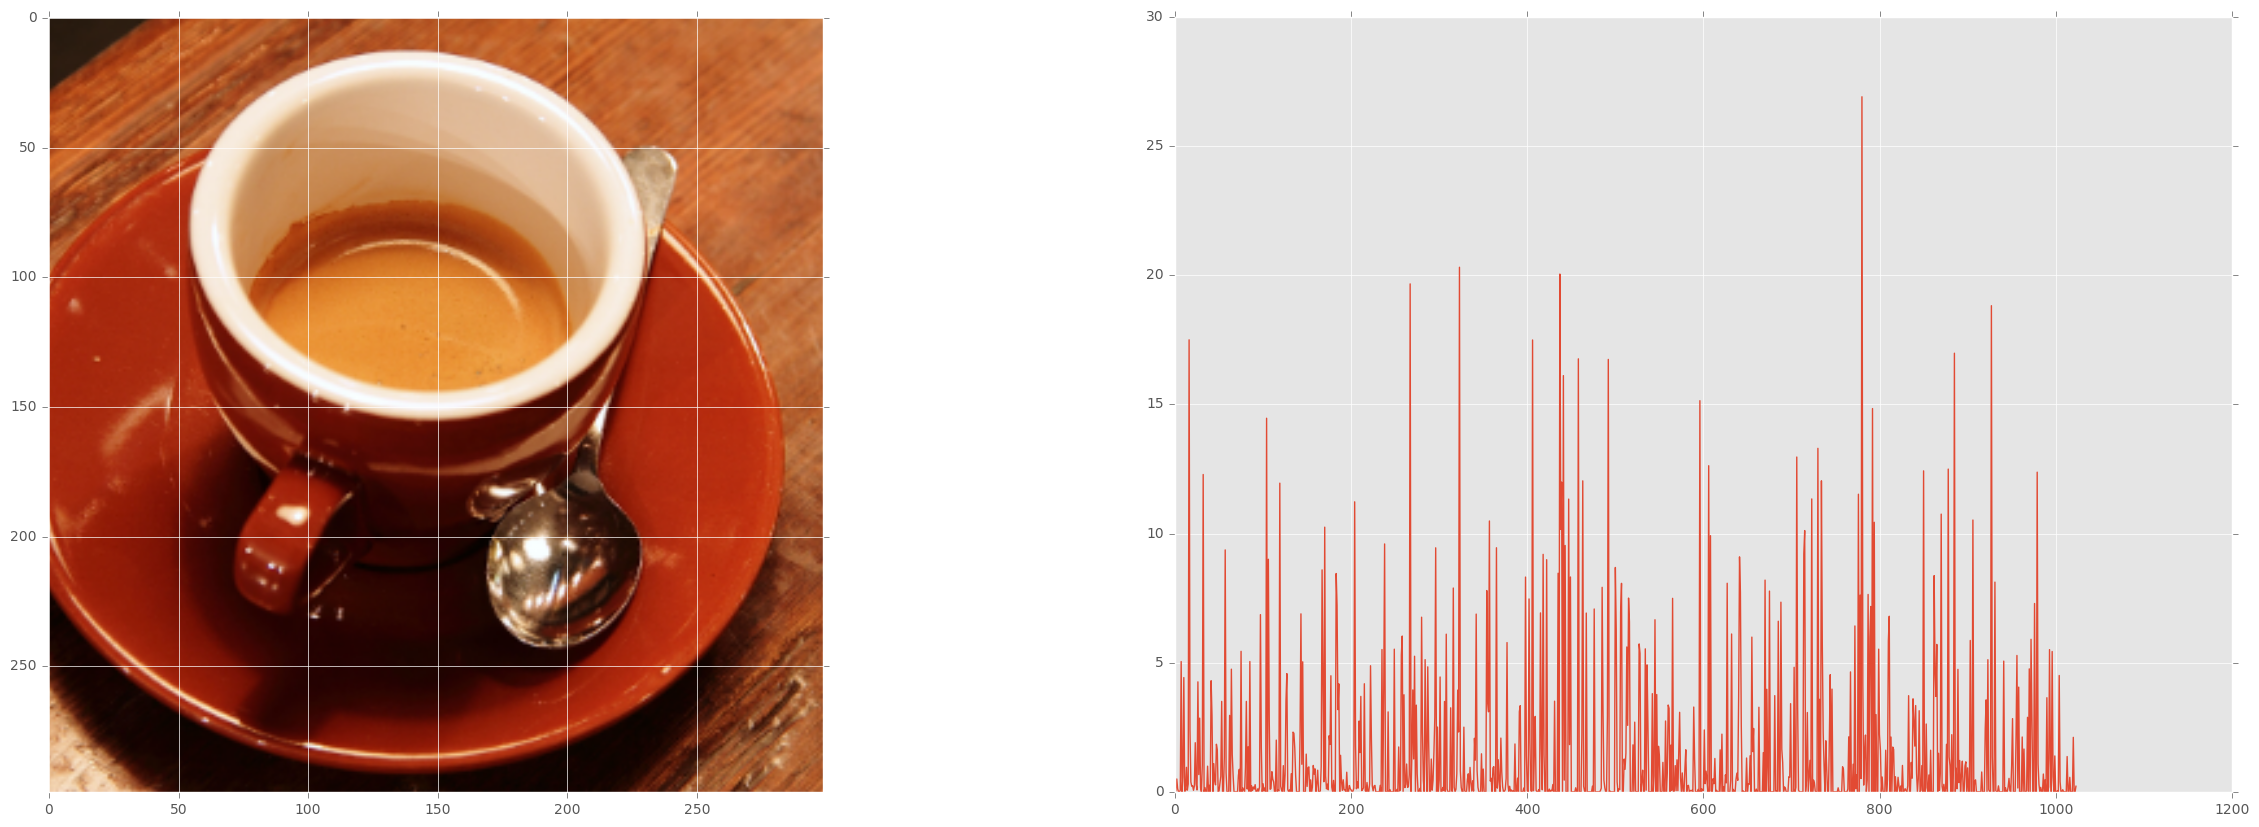

In [15]:
# Get an image
x = g.get_tensor_by_name(names[0] + ':0')
avg_pool = g.get_tensor_by_name('inception/avgpool0/reshape' + ':0')

# Get coffee image
from skimage.data import coffee
img = net['preprocess'](coffee())
img_4d = img[np.newaxis]
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    fea = avg_pool.eval(feed_dict={x: img_4d})[0]

# Plot image and extracted features
fig, axs = plt.subplots(1,2, figsize=(30,10))
axs[0].imshow((img+117)/255.0)
axs[1].plot(fea)
print(fea.shape)

### Let's apply this for the all images of the dataset.

In [17]:
## Seen classes
N = 8855 # the number of images for seen classes
k = 1024 # feature dimension
d = 312  # attribute dimension
c = 150   # the number of unseen classes

imgs_train_fea      = np.zeros((N, k))
S_train             = np.zeros((N, d))
index_counter_train = 0
for i in range(c): #150
    print(index_counter_train)
    for j in range(images.shape[0]):
        if (images[j].split('/')[0] == train_classes[i][0].split(' ')[1]):
            #print(os.path.join(PATH, images[j]))
            im = plt.imread(os.path.join(PATH, images[j]));
            im_shape_length = len(im.shape)
            
            # if the image does not have 3 chanells 
            if im_shape_length == 2: # if image 2-dimensional, then convert it to 3-dimensional
                
                im_temp = np.zeros((im.shape[0], im.shape[1], 3))
                
                im_temp[:, :, 0]  = im
                im_temp[:, :, 1]  = im
                im_temp[:, :, 2]  = im
                
                fea = data_augment(im_temp, net)
                imgs_train_fea[index_counter_train, :] = fea        
            else:     
                fea = data_augment(im, net)
                imgs_train_fea[index_counter_train, :] = fea
                  
            S_train[index_counter_train, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
            index_counter_train += 1
            
# Unseen classes
N = 2933 # the number of images for seen classes
k = 1024 # feature dimension
d = 312  # attribute dimension
c = 50   # the number of unseen classes
imgs_test_fea      = np.zeros((N, k))
imgs_test          = np.zeros((N, k))
S_test             = np.zeros((N, d))
Y_test             = []
index_counter_test = 0

for i in range(c):
    print(index_counter_test)
    for j in range(images.shape[0]):
        if (images[j].split('/')[0] == test_classes[i]):
            #print(os.path.join(PATH, images[j]))
            im = plt.imread(os.path.join(PATH, images[j]));
            im_shape_length = len(im.shape)
            if im_shape_length == 2: # if image 2-dimensional, then convert it to 3-dimensional
                
                im_temp = np.zeros((im.shape[0], im.shape[1], 3))
                
                im_temp[:, :, 0]  = im
                im_temp[:, :, 1]  = im
                im_temp[:, :, 2]  = im
                
                fea = data_augment(im_temp, net)
                imgs_test_fea[index_counter_test, :] = fea        
            else:     
                fea = data_augment(im, net)
                imgs_test_fea[index_counter_test, :] = fea
                    
            Y_test.append(int(images[j][0:3])-1)
            #print(int(images[j][0:3])-1)
            S_test[index_counter_test, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
            index_counter_test += 1



### Zero-shot classification: transfer learning

In [ ]:
# Solving |XW-Y|_F^2 + |W|_F^2 to learn embedding function W
# W = (X^TX + lambda*I)^{-1}X^TS, this is a analityc solution for ridge regression
XtX =  np.matmul(np.transpose(imgs_train_fea), imgs_train_fea)
XtS =  np.matmul(np.transpose(imgs_train_fea), S_train)
W   =  np.matmul(inv(XtX + .005 * np.eye(1024)), XtS) 

S_test_proto = []
te_cl_id     = []

for a_i in test_classes:
    a_i_ind = int(a_i[0][0:3])-1
    S_test_proto.append(ATTRIBUTES[a_i_ind,:])
    te_cl_id.append(a_i_ind)

# Projection to embedding space
S_est = np.matmul((imgs_test_fea), W)

acc_ridge_zsl, Y_est   = knn_zsl_el(np.transpose(NormaliseRows( S_est)), np.array(S_test_proto), np.array(Y_test),  np.array(te_cl_id))
print('ZSL Accuracy (Ridge regression): ', acc_ridge_zsl)

Accuracy using inception is about <strong>40.5%.</strong> The figure for VGG16 is about 34.5%.

Some results of pretrained models on CUB bird dataset. 'w/' means I used bounding box to crop bird images, while 'w/o' refers to without bounding box. As we can see from the table below, the highest accuracy is obtained by Inception V4 w/ bbox with 44.6%. Interestingly, when I use the pre-trained model from this course I can get lower performance. This is maybe because of a number of factors such as normalisation, mean image and image size, and I do not check them carefully.  If you want to know how I extracted features for different models, please go to <a name='fea_ext'>Extra</a> I give a code with some explanation.


|   Model                       |  Accuracy w/ bbox (%)  |  Accuracy w/o bbox (%)  |                    
|-------------------------------|------------------------| ------------------------|  
|   Inception V1                |       37.5             |        35.6             |
|   Inception V2                |       38.2             |        33.4             |
|   Inception V3                |       41.0             |        41.9             |
|   Inception V4                |       44.6             |        40.3             |
|   Inception-Resnet v2 (V5)    |       42.1             |        -                |
|   Inception V5 (this course)  |       38.5             |        40.5             |
|   Resnet 50                   |       29.4             |        -                |
|   Resnet 101                  |       29.9             |        -                |
|   VGG 16                      |       34.5             |        -                |
|   VGG 16 (this course)        |       34.5             |        -                |
                                             
'-' means I do not do experimenets assuming I would get similar results anyway. 


<a name='ae_for_zsl'> </a>
# Part 3 - Convolutional Autoencoder for Zero-shot Learning
In this section, we learn features with convolutional autoencoder. Instead of using features from VGG and inception models. We are going to train a model on CUB dataset with convolutinal autoencoder. Then, we only use encoder part for the feature extraction. Only difference from Part 2 is that we are learning featuring from scratch. Let's see how much we can get. If we get about 14% then it is fine. This is because if one uses hand crafted low-level features such as, fisher vector, HOG and SIFT features, one may get about 13.3%.

First, let's read images, make all the images [100, 100, 3] and save them.

In [ ]:
# Crop every image using bounding box if available, and save them:
from PIL import Image
PATH      = '/home/elyor/deep_learning/CUB/CUB_200_2011/images/'
PATH_SAVE = '/home/elyor/deep_learning/CUB/CUB_200_2011_box/images/'
PATH_BOX  = '/home/elyor/deep_learning/CUB/CUB_200_2011_box/images/'

images = []
with open('/home/elyor/deep_learning/CUB/CUB_200_2011/images.txt', newline='') as inputfile:
    for row in csv.reader(inputfile):
        images.append(row[0].split(' '))
        
boxes = []
with open('/home/elyor/deep_learning/CUB/CUB_200_2011/bounding_boxes.txt', newline='') as inputfile:
    for row in csv.reader(inputfile):
        boxes.append(row[0].split(' '))

for i in range(len(images)):
    index  = images[i][0]
    im     = Image.open(PATH + images[i][1])
    
    box_i  = boxes[i][1:]
    x      = int(float(box_i[0]))
    y      = int(float(box_i[1]))
    width  = int(float(box_i[2]))
    height = int(float(box_i[3]))
    
    im_crop = im.crop((x, y, x + width, y + height))
    im_crop = np.array(im_crop)
    rsz     = imresize(im_crop, (128, 128))
    
    plt.imsave(PATH_SAVE + images[i][1], rsz)
    
    # Track
    if i%500 == 0:
        print(i)


## Network specifications:

In [24]:
# network input / placeholders for train (bn) and dropout
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 100, 100, 3], 'x')

# 2d -> 4d if convolution
x_tensor = utils.to_tensor(x)
current_input = x_tensor

n_filters    = [64, 128, 128]
filter_sizes = [4, 4, 4]
activation   = tf.nn.relu
n_code       = 1024
Ws           = []
shapes       = []
input_shape  = [100, 100, 3]

## Building Encoder

In [25]:
# Build the encoder
#from libs.batch_norm import batch_norm

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope('encoder/{}'.format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        h, W = utils.conv2d(x=current_input, n_output=n_output, k_h=filter_sizes[layer_i], k_w=filter_sizes[layer_i])
        #h = activation(batch_norm(h, phase_train, 'bn' + str(layer_i)))
        h = activation(h)
        print(h.get_shape().as_list())
        Ws.append(W)
        current_input = h

shapes.append(current_input.get_shape().as_list())


with tf.variable_scope('fc_encoder'): 
    dims = current_input.get_shape().as_list()
    flattened = utils.flatten(current_input)
            
    z= utils.linear(flattened, n_code, name='z')[0]
    z= activation(h)
    
    size = dims[1] * dims[2] * dims[3] 
    h = utils.linear(z, size, name='fc_t2')[0]
    current_input = activation(h)
            
    current_input = tf.reshape(
        current_input, tf.pack([
                tf.shape(current_input)[0],
                dims[1],
                dims[2],
                dims[3]]))
    

print(dims)

[None, 50, 50, 64]
[None, 25, 25, 128]
[None, 13, 13, 128]
[None, 13, 13, 128]


## Building Decoder

In [27]:
shapes.reverse()
n_filters.reverse()
Ws.reverse()

n_filters += [input_shape[-1]]
print(n_filters)

for layer_i, n_output in enumerate(n_filters[1:]):
        #print(layer_i)
        with tf.variable_scope('decoder/{}'.format(layer_i)):
            shape = shapes[layer_i + 1]
            h, W = utils.deconv2d(x=current_input,
                                  n_output_h=shape[1],
                                  n_output_w=shape[2],
                                  n_output_ch=shape[3],
                                  n_input_ch=shapes[layer_i][3],
                                  k_h=filter_sizes[layer_i],
                                  k_w=filter_sizes[layer_i])
            
            h = activation(h)
            current_input = h

y = current_input
x_flat = utils.flatten(x)
y_flat = utils.flatten(y)

0
1
2


## Loss

In [28]:
# L2 loss
with tf.variable_scope('loss'):
    loss_x = tf.reduce_sum(tf.squared_difference(x_flat, y_flat), 1)
    cost = tf.reduce_mean(loss_x)

## Graph

In [29]:
graph = tf.get_default_graph()
nb_utils.show_graph(graph.as_graph_def())

## Training

In [ ]:
n_examples = 100
learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Saving weights
saver = tf.train.Saver()

# Restore previous sess
# ckpt = tf.train.get_checkpoint_state('./')
# print(ckpt.model_checkpoint_path)
# saver.restore(sess, ckpt.model_checkpoint_path)

# Fit all training data
ckpt_name = 'simple_cae_v4.ckpt'
t_i = 0
batch_i = 0
batch_size = 100
n_epochs = 30000
test_xs = ds_te.X[:100] 
utils.montage(test_xs, 'winchester6/test_xs.png')


## Start training
for epoch_i in range(n_epochs):
    print('Epoch:', epoch_i)
    train_i = 0
    train_cost = 0
    for batch_xs, batch_ss in ds_tr.train.next_batch(batch_size=100):
        train_cost += sess.run([cost, optimizer],feed_dict={x: batch_xs})[0]
              
        train_i += 1
        if batch_i % 80 == 0:
            # Plot example recontructions 
            recon = sess.run(y, feed_dict={x: test_xs})
            m = utils.montage(recon, 'winchester6/reconstruction_%08d.png' % t_i)
                
            t_i += 1
            
        batch_i += 1
        
    print('train: ', train_cost / train_i)
    save_path = saver.save(sess, "./" + ckpt_name, global_step = 90, write_meta_graph=False)
    print("Model saved in file: %s" % save_path)


## Feature extraction
Up until now, we have finished the training. So, we can use encoder part to extract features like so:

In [ ]:
# We extract features for training data and test data
train_cae_fea = np.zeros((8855, 1024))
test_cae_fea = np.zeros((2933, 1024))

# Extracting features for train data
for i in range(8855):
    if i%500 == 0:
        print(i)
    im_i = imgs_train[i,:,:,:]
    train_cae_fea[i, :] = sess.run(z, feed_dict={
            x: im_i[np.newaxis]})

# Extracting features for test data
for i in range(2933):
    if i%500 == 0:
        print(i)
    im_i = imgs_test[i,:,:,:]
    test_cae_fea[i, :] = sess.run(z, feed_dict={
            x: im_i[np.newaxis]})


print('Feature extraction is finished.')

## Zero-shot classification: Autoencoder

In [ ]:
# Solving |XW-Y|_F^2 + |W|_F^2 to learn embedding function W
# W = (X^TX + lambda*I)^{-1}X^TS, this is a well-known closed form solution for ridge regression
XtX =  np.matmul(np.transpose(imgs_train_fea), imgs_train_fea)
XtS =  np.matmul(np.transpose(imgs_train_fea), S_train)
W   =  np.matmul(inv(XtX + .005 * np.eye(1024)), XtS) 

S_test_proto = []
te_cl_id     = []

for a_i in test_classes:
    a_i_ind = int(a_i[0][0:3])-1
    S_test_proto.append(ATTRIBUTES[a_i_ind,:])
    te_cl_id.append(a_i_ind)

# Projection to embedding space
S_est = np.matmul((imgs_test_fea), W)

Acc, Y_est   = knn_zsl_el(np.transpose(NormaliseRows( S_est)), np.array(S_test_proto), np.array(Y_test),  np.array(te_cl_id))
print('ZSL Accuracy: ', Acc)
# You will get 14.3% accuracy

Some results: we can get 14.3% compared to 13.3% that is obrained by low-level features. Note that low-level features are crafted manually. In short, autoencoder can learn features in a unsupervised way for the better.

|   Model  |  ZSL accuracy (%)  |
|----------|--------------------|
|   Regression using low-level features     |      13.3              |
|   <strong>Regression using features from encoder</strong>          |      <strong>14.3</strong>              |


<a name='dr_zsl'></a>
# Part 4 - Deep Regression for Zero-shot Learning
In Part 1, we see simple regression. That is, there are two steps to do zero-shot classification: (1) Extracting features and (2) Learning embedding. Now in this section we unifiy two stages and learn (1) and (2) end-to-end manner.

## Artitechture specification

In [31]:
# Network input / placeholders for train (bn) and dropout
tf.reset_default_graph()
x        = tf.placeholder(tf.float32, [None, 100, 100, 3], 'x')
semantic = tf.placeholder(tf.float32, [None, 312], 'semantic')

# 2d -> 4d if convolution
x_tensor = utils.to_tensor(x)
current_input = x_tensor

n_filters    = [64, 128, 256, 256]
filter_sizes = [4, 4, 4, 3]
activation   = tf.nn.relu
n_code       = 1024
Ws           = []
shapes       = []
input_shape  = [100, 100, 3]

## Build Encoder

In [32]:
# Build the encoder to learn reprensentation
for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope('Encoder/{}'.format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        h, W = utils.conv2d(x=current_input, n_output=n_output, k_h=filter_sizes[layer_i], k_w=filter_sizes[layer_i])
        h = activation(h)
        print(h.get_shape().as_list())
        Ws.append(W)
        current_input = h

with tf.variable_scope('FC'): 
    dims = current_input.get_shape().as_list()
    flattened = utils.flatten(current_input)
                
    z = utils.linear(flattened, n_code, name='z')[0]
    z = activation(z)
    print(z.get_shape().as_list())
    
    s = utils.linear(z, 312, name='fc_1')[0]
    s = activation(s)
    print(s.get_shape().as_list())

    

[None, 50, 50, 64]
[None, 25, 25, 128]
[None, 13, 13, 256]
[None, 7, 7, 256]
[None, 1024]
[None, 312]


## Loss

In [33]:
with tf.variable_scope('loss'):
    loss_s = tf.reduce_sum(tf.squared_difference(s, semantic), 1)
    cost = tf.reduce_mean(loss_s)

## Graph

In [34]:
graph = tf.get_default_graph()
nb_utils.show_graph(graph.as_graph_def())

## Training
For training we use GradientDescentOptimizer insted of Adam optimiser, because it converged faster.

In [ ]:
#### n_examples = 100
learning_rate = 0.01
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.GradientDescentOptimizer (learning_rate=learning_rate).minimize(cost)

# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Saving weights
saver = tf.train.Saver()
S_train_norm = NormaliseRows(S_train)

# Restore previous sess
ckpt = tf.train.get_checkpoint_state('./drzsl_norm_s')
print(ckpt.model_checkpoint_path)
saver.restore(sess, ckpt.model_checkpoint_path)

# Fit all training data
ckpt_name  = 'regression_zsl_v1.ckpt'
t_i        = 0
batch_i    = 0
batch_size = 100
n_epochs   = 30000

for epoch_i in range(n_epochs):
    print('Epoch:', epoch_i)
    train_i = 0
    train_cost = 0
    for _, indx in ds_tr.train.next_batch(batch_size=100):
        train_cost += sess.run([cost, optimizer], feed_dict={
                x: imgs_train[indx, :, :, :], 
                semantic: S_train_norm[indx, :]
            })[0]      
        train_i += 1
        batch_i += 1
        
    print('train: ', train_cost / train_i)
    save_path = saver.save(sess, "./" + ckpt_name, global_step = 90, write_meta_graph=False)
    print("Model saved in file: %s" % save_path)

## ZSL classification: Deep Regression

In [ ]:
# We extract features for training data and test data
test_cae_fea = np.zeros((2933, 312))

# Extracting features for test data
for i in range(2933):
    if i%500 == 0:
        print(i)
    im_i = imgs_test[i,:,:,:]
    # Now this is our regresion function
    test_cae_fea[i, :] = sess.run(s, feed_dict={
            x: im_i[np.newaxis]})

S_test_proto = []
te_cl_id     = []

for a_i in test_classes:
    a_i_ind = int(a_i[0][0:3])-1
    S_test_proto.append(ATTRIBUTES[a_i_ind,:])
    te_cl_id.append(a_i_ind)

S_est = (test_cae_fea)

Acc, Y_est   = knn_zsl_el(np.transpose(NormaliseRows(S_est)), (np.array(S_test_proto)), np.array(Y_test),  np.array(te_cl_id))
print('ZSL Accuracy: ', Acc)

Some results are given below. We can achieve with simple network 24.5%, while we can achieve 13.3% with low level features which are designed carefully with manual work.

|   Model  |  ZSL accuracy (%)  |
|----------|--------------------|
|   Regression(low-level features - fisher vector)    |      13.3              |
|   Deep Regression(deep features)         |      24.5              |


<a name='fea_ext'></a>
# Part 5 - Extra
I include slim_birds.ipynb file with this project that shows: (1) how to use TF-Slim library to extract features from Incetion V1-5, and Resnet and VGG; (2) Fine-tuning.




# References

C. H. Lampert, H. Nickisch and S. Harmeling, "Attribute-Based Classification for Zero-Shot Visual Object Categorization," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 36, no. 3, pp. 453-465, March 2014.

Akata, Zeynep, et al. "Evaluation of output embeddings for fine-grained image classification." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.